In [203]:
import ehrapy as ep
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import graphviz

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)


## Load data with drugcats added

In [204]:
adata = ep.io.read_csv("./adata_pneumonia_drugcats_added.csv", sep="\t")
adata


2023-09-08 17:21:42,053 - root INFO - Added all columns to `obs`.
2023-09-08 17:21:42,172 - root INFO - Transformed passed dataframe into an AnnData object with n_obs x n_vars = `277` x `1291`.


AnnData object with n_obs × n_vars = 277 × 1291
    uns: 'numerical_columns', 'non_numerical_columns'
    layers: 'original'

In [205]:
adata.to_df().filter(regex="orti").sum(axis=0).sort_values(ascending=False)
# drugcat_Anti_Infective_Agents
# drugcat_Antibacterials_for_Systemic_Use
# drugcat_Nephrotoxic_agents
# drugcat_Cardiovascular_Agents
# drugcat_Immunosuppressive_Agents
# drugcat_Cytochrome_P_450_Enzyme_Inhibitors
# drugcat_Blood_and_Blood_Forming_Organs
# drugcat_Central_Nervous_System_Agents
# drugcat_P_glycoprotein_inhibitors

drugcat_Corticosteroids                                          159.0
drugcat_Corticosteroid_Hormone_Receptor_Agonists                 142.0
drugcat_Corticosteroids,_Dermatological_Preparations             142.0
drugcat_Corticosteroids,_Potent_Group_III                        139.0
drugcat_Corticosteroids_Acting_Locally                           139.0
drugcat_Corticosteroids_for_Systemic_Use                         132.0
drugcat_Glucocorticoids                                          127.0
drugcat_Corticosteroids_for_Systemic_Use,_Plain                   24.0
drugcat_Corticosteroids,_Moderately_Potent_Group_II               24.0
drugcat_Corticosteroids_for_Local_Oral_Treatment                  24.0
drugcat_Mineralocorticoid_Receptor_Antagonists                    21.0
drugcat_Mineralocorticoid_Aldosterone_Receptor_Antagonists        21.0
drugcat_Organic_Anion_Transporting_Polypeptide_2B1_Inhibitors      6.0
drugcat_11_Hydroxycorticosteroids                                  0.0
drugca

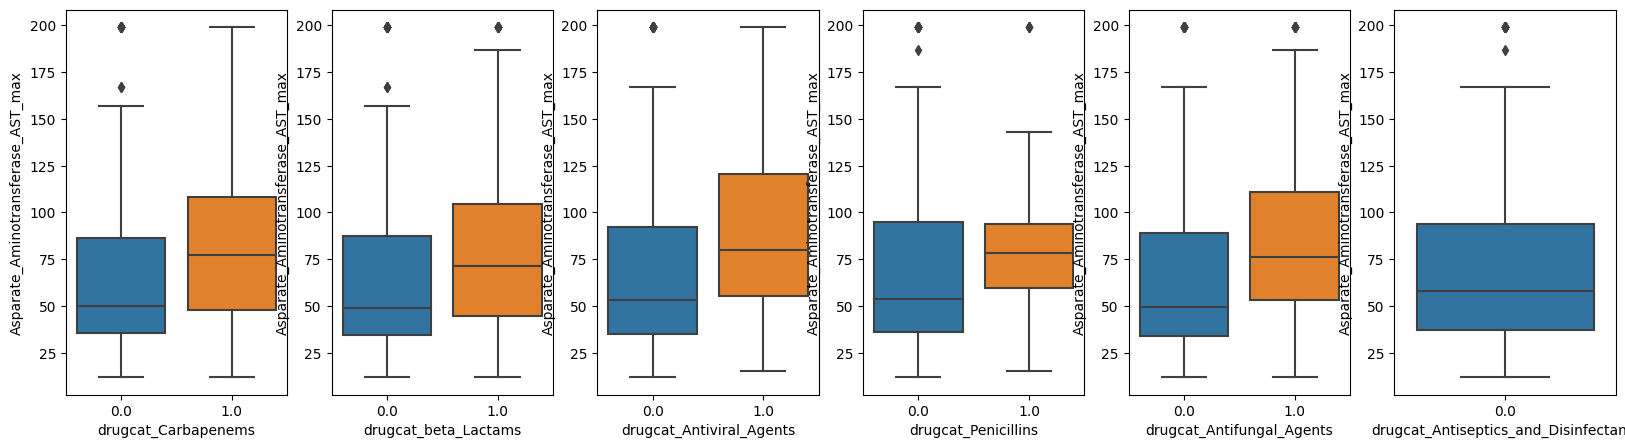

In [206]:
import seaborn as sns

treat = [
    "drugcat_Carbapenems", # 2 columns
    "drugcat_beta_Lactams", # 13 columns
    "drugcat_Antiviral_Agents", # 2 columns
    "drugcat_Penicillins",  # 4 columns
    "drugcat_Antifungal_Agents", # 5 columns 
    "drugcat_Antiseptics_and_Disinfectants" # 2 columns
]


fig, axs = plt.subplots(ncols=len(treat), nrows=1, figsize=(20, 5))


for idx, t in enumerate(treat):
    sns.boxplot(
        data=adata.to_df()[["Asparate_Aminotransferase_AST_max", t]],
        y="Asparate_Aminotransferase_AST_max",
        x=t,
        ax=axs[idx])

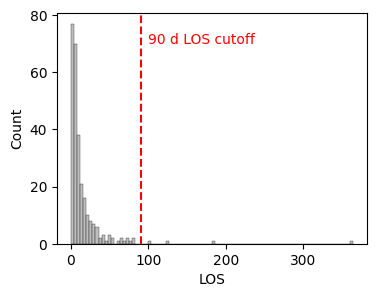

In [207]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.histplot(
    data=adata.to_df(),
    x="LOS",    
    color="darkgrey",
    ax=ax,
    edgecolor="black",
)
ax.axvline(90, color="red", linestyle="--")
ax.text(100, 70, "90 d LOS cutoff", color="red", fontsize=10)

plt.savefig("./Figure5cutoff.png", dpi=300)
plt.savefig("./Figure5cutoff.pdf")

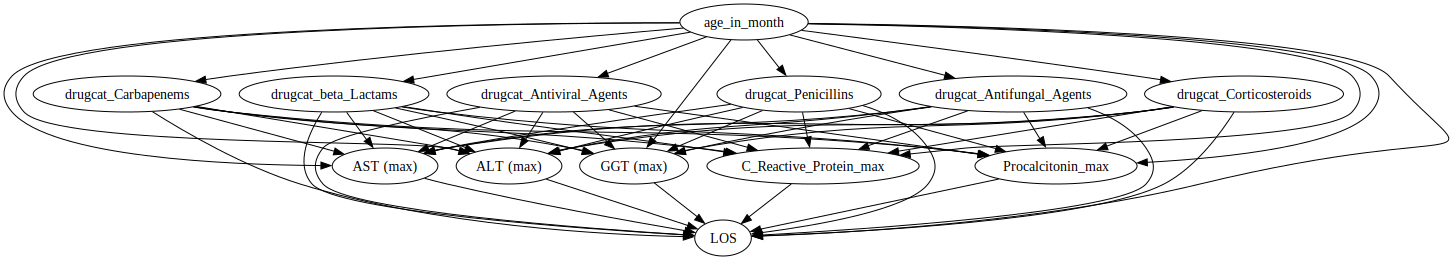

                   treatment  estimate placebo_effect placebo_pval  \
0        drugcat_Carbapenems  1.212356         -0.000        0.000   
0       drugcat_beta_Lactams -2.715868         -0.000        0.000   
0   drugcat_Antiviral_Agents -2.829381         -0.000        0.000   
0        drugcat_Penicillins  4.722282         -0.000        0.000   
0  drugcat_Antifungal_Agents  1.230961         -0.000        0.000   
0    drugcat_Corticosteroids -3.250948         -0.000        0.000   

  randomcc_effect randomcc_pval subset_effect subset_pval unobservedcc_effect  \
0           1.209         0.486         1.423       0.379               1.054   
0          -2.722         0.489        -2.544       0.470              -2.623   
0          -2.878         0.449        -2.270       0.323              -2.318   
0           4.712         0.467         4.931       0.457               4.911   
0           1.276         0.449         1.380       0.480               1.337   
0          -3.261      

In [208]:
treatments = [
    "drugcat_Carbapenems",
    "drugcat_beta_Lactams",
    "drugcat_Antiviral_Agents",
    "drugcat_Penicillins",
    "drugcat_Antifungal_Agents",
    "drugcat_Corticosteroids"
]


causal_graph = """digraph {
Asparate_Aminotransferase_AST_max[label="AST (max)"];
Alanine_Aminotransferase_ALT_max[label="ALT (max)"];
Gamma_Glutamyltransferase_max[label="GGT (max)"];

age_in_month -> LOS;
age_in_month -> Asparate_Aminotransferase_AST_max;
age_in_month -> Alanine_Aminotransferase_ALT_max;
age_in_month -> Gamma_Glutamyltransferase_max;
age_in_month -> C_Reactive_Protein_max;
age_in_month -> Procalcitonin_max;

C_Reactive_Protein_max -> LOS;
Procalcitonin_max -> LOS;
Asparate_Aminotransferase_AST_max -> LOS;
Alanine_Aminotransferase_ALT_max -> LOS;
Gamma_Glutamyltransferase_max -> LOS;
"""

for treatment in treatments:
    causal_graph += f"""
    {treatment} -> Asparate_Aminotransferase_AST_max;
    {treatment} -> Alanine_Aminotransferase_ALT_max;
    {treatment} -> Gamma_Glutamyltransferase_max;
    {treatment} -> C_Reactive_Protein_max;
    {treatment} -> Procalcitonin_max;
    {treatment} -> LOS;
    age_in_month -> {treatment};
    """

causal_graph += "}"

results = pd.DataFrame()

g = graphviz.Source(causal_graph)
display(g)
for treatment in treatments:
    e, refute = ep.tl.causal_inference(
        adata=adata[adata.to_df()["LOS"] <= 90], 
        graph=causal_graph,
        treatment=treatment, 
        outcome="LOS", 
        estimation_method="backdoor.linear_regression",
        refute_methods = [
            "placebo_treatment_refuter",
            "random_common_cause",
            "data_subset_refuter",
            "add_unobserved_common_cause"
        ],
        print_causal_estimate=False,
        print_summary=False,
        show_graph=False,
        show_refute_plots="colormesh",
        return_as="estimate+refute",
        attempts=3
    )
    tmp = pd.DataFrame({
        "treatment": [treatment],
        "estimate": [e.value],
        "placebo_effect": [None],
        "placebo_pval": [None],
        "randomcc_effect": [None],
        "randomcc_pval": [None],
        "subset_effect": [None],
        "subset_pval": [None],
        "unobservedcc_effect": [None],
        "unobservedcc_pval": [None],
    })
    try:
        tmp["placebo_effect"] = refute["Refute: Use a Placebo Treatment"]["New effect"]
        tmp["placebo_pval"] = refute["Refute: Use a Placebo Treatment"]["p-value"]
    except:
        pass
    try:
        tmp["randomcc_effect"] = refute["Refute: Add a random common cause"]["New effect"]
        tmp["randomcc_pval"] = refute["Refute: Add a random common cause"]["p-value"]
    except:
        pass
    try:
        tmp["subset_effect"] = refute["Refute: Use a subset of data"]["New effect"]
        tmp["subset_pval"] = refute["Refute: Use a subset of data"]["p-value"]
    except:
        pass
    try:
        tmp["unobservedcc_effect"] = refute["Refute: Add an Unobserved Common Cause"]["New effect"]
        tmp["unobservedcc_pval"] = refute["Refute: Add an Unobserved Common Cause"]["p-value"]
    except:
        pass
    
    results = pd.concat([results, tmp])
    
print(results)

## Figure 5c

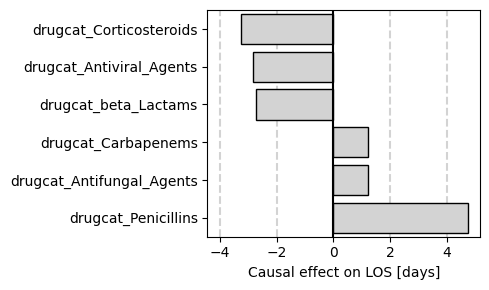

In [209]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

ax = sns.barplot(
    data=results.sort_values(by="estimate", ascending=True),
    y="treatment",
    x="estimate",
    color="lightgrey",
    ax=ax,
    edgecolor="black",
    zorder=2,
)
ax.axvline(0, color="black", linestyle="-")

for i in range(-4, 6, 2):
    ax.axvline(i, color="lightgrey", linestyle="--", zorder=0)

ax.set_ylabel("")
ax.set_xlabel("Causal effect on LOS [days]")
ax.set_xticks([-4, -2, 0, 2, 4])

plt.tight_layout()
plt.savefig("./Figure5c.png", dpi=300)
plt.savefig("./Figure5c.pdf")

## Term counts figure

                  term  pos  neg     ratio  count                    drugcat
67     Corticosteroids  159  118  1.347458      6    drugcat_Corticosteroids
187       beta-Lactams  123  154  0.798701     13       drugcat_beta_Lactams
209        Carbapenems   98  179  0.547486      2        drugcat_Carbapenems
241  Antifungal Agents   93  184  0.505435      5  drugcat_Antifungal_Agents
328   Antiviral Agents   52  225  0.231111      2   drugcat_Antiviral_Agents
390        Penicillins   37  240  0.154167      4        drugcat_Penicillins


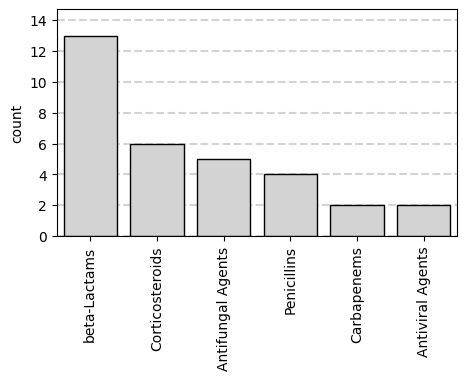

In [230]:
term_counts = pd.read_csv("./term_counts_and_ratios.csv", sep=";")

tmp_for_plot = term_counts[term_counts["drugcat"].isin(treatments)].copy()
print(tmp_for_plot)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.barplot(
    y="count", 
    x="term", 
    data=tmp_for_plot.sort_values(by="count", ascending=False),
    color="lightgrey",
    ax=ax,
    edgecolor="black",
    zorder=2,
)

plt.tight_layout()
for i in range(0, 16, 2):
    ax.axhline(i, color="lightgrey", linestyle="--", zorder=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_xlabel("");

plt.savefig("./FigureSx_drugs_per_keyword.png", dpi=300)
plt.savefig("./FigureSx_drugs_per_keyword.pdf")

## Ratio-plot

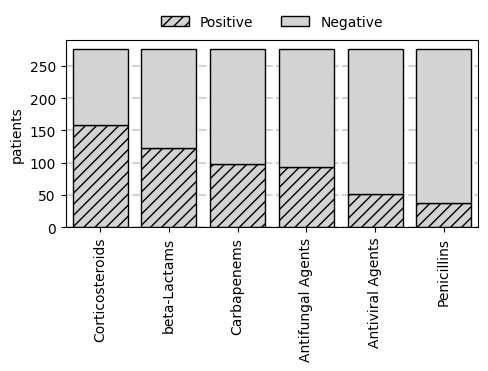

In [231]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

sns.barplot(
    x='term',
    y='pos',
    data=tmp_for_plot.sort_values(by="ratio", ascending=False), 
    color="lightgrey",
    ax=ax,
    edgecolor="black",
    zorder=2,
    label="Positive",
)

sns.barplot(
    x='term',
    y='neg',
    data=tmp_for_plot.sort_values(by="ratio", ascending=False), 
    color="lightgrey",
    ax=ax,
    edgecolor="black",
    zorder=2,
    bottom=tmp_for_plot['pos'],
    label="Negative",
)

patterns = ['/', 'x', '\\']
for bar in ax.patches[:6]:
    bar.set_hatch("///")

# Add a legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.20), ncol=2, frameon=False)
plt.tight_layout()
for i in range(0, 300, 50):
    ax.axhline(i, color="lightgrey", linestyle="--", zorder=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_xlabel("");
ax.set_ylabel("patients");
plt.savefig("./FigureSx_ratios.png", dpi=300)
plt.savefig("./FigureSx_ratios.pdf")

## Make figure

Text(0, 0.5, '')

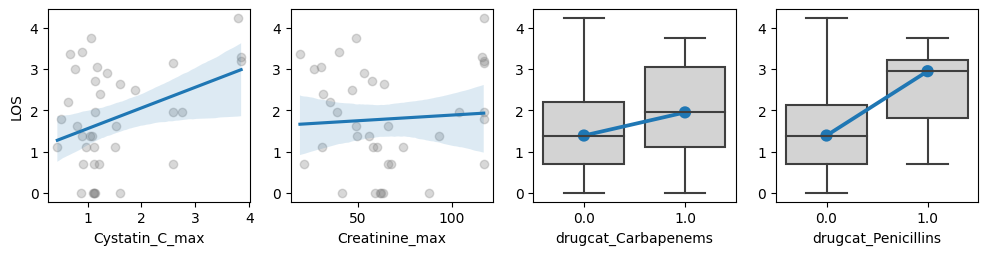

In [212]:
data_for_plot = adata_dead.to_df()[[
    "LOS",
    "drugcat_Carbapenems",
    "drugcat_Penicillins",
    "Cystatin_C_max",
    "Creatinine_max",
]]

data_for_plot["LOS"] = np.log1p(data_for_plot["LOS"])

fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(12, 2.5))

sns.regplot(data=data_for_plot, x="Cystatin_C_max", y="LOS", scatter_kws={"alpha":0.3, "color": "grey"}, ax=axs[0])
axs[0].set_ylabel("LOS")

sns.regplot(data=data_for_plot, x="Creatinine_max", y="LOS", scatter_kws={"alpha":0.3, "color": "grey"}, ax=axs[1])
axs[1].set_ylabel("")

sns.boxplot(data=data_for_plot, x="drugcat_Carbapenems", y="LOS", boxprops={"facecolor": "lightgrey"}, ax=axs[2])
sns.pointplot(data=data_for_plot.groupby('drugcat_Carbapenems', as_index=False).median(), x='drugcat_Carbapenems', y='LOS', ax=axs[2])
axs[2].set_ylabel("")

sns.boxplot(data=data_for_plot, x="drugcat_Penicillins", y="LOS", boxprops={"facecolor": "lightgrey"}, ax=axs[3])
sns.pointplot(data=data_for_plot.groupby('drugcat_Penicillins', as_index=False).median(), x='drugcat_Penicillins', y='LOS', ax=axs[3])
axs[3].set_ylabel("")
